In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

Función para calcular el precio de una Call europea vainilla, usando un árbol trinomial.

In [2]:
def Call_Eu_Trinomial(Spot, Strike, T, r, v, n):
    alpha = r - (0.5 * v * v)
    K = T / n
    h = v * math.sqrt(3.0 * K)
    u = math.exp(h)
    d = 1/u

    pd = 1/6 - math.sqrt(K/12/v/v) * (r-v*v/2)
    pu = 1/6 + math.sqrt(K/12/v/v) * (r-v*v/2)
    pm = 1.0 - pu - pd

    exp_rT = math.exp(-r * T / n)

    A = np.zeros((2 * n + 1, n+1))
    A[n,0] = Spot

    #Árbol con los precios por cada tiempo
    for j in range(1, n+1):
        for i in range(n-j, n+j+1):
            cota = n
            if cota > i:
                A[i,j] = A[i+1,j-1] * u
            elif cota < i:
                A[i,j] = A[i-1,j-1] * d
            else:
                A[i,j] = A[i,j-1]

    #Op tendrá el valor de la opcion en cada nodo del arbol de precios S
    Op = np.zeros((2*n+1,n+1))

    for i in range(2 * n + 1):
        Op[i,n] = max(A[i,n] - Strike, 0)

    for i in range(1, 2 * n):
        Op[i,n - 1] = exp_rT * (pu * Op[i-1, n] + pm * Op[i,n] + pd * Op[i+1, n])

    for j in range(n-2, -1, -1):
        for i in range(n-j, n+j+1):
            Op[i,j] = exp_rT * (pu * Op[i-1, j+1] + pm * Op[i, j+1] + pd * Op[i+1, j+1])
    return Op[n,0]

Armamos una lista con el error cuadrático entre el precio de una call aproximado con el modelo trinomial y el precio obtenido de fórmula analítica con Black Scholes para distintas cantidades de pasos.

In [3]:
def Black_Scholes(Spot, Strike, T, r, v):
    d1=(np.log(Spot/Strike) + (r + (v**2)/2)*T)/(v*np.sqrt(T))
    d2=d1 - v*np.sqrt(T)
    return Spot*norm.cdf(d1) - Strike*np.exp(-r*T)*norm.cdf(d2)

In [4]:
Spot = 100  # Precio Spot
Strike = 130  # Precio Strike
T = 3  # Años para maduración
r = 0.05 # Tasa libre de riesgo
v = 0.2  # Volatilidad
n = 700 # Numero de pasos temporales
c = Call_Eu_Trinomial(Spot, Strike, T, r, v, n)

In [5]:
Black_Scholes_Price = Black_Scholes(Spot, Strike, T, r, v)
Error = [(Black_Scholes_Price - Call_Eu_Trinomial(Spot, Strike, T, r, v, i))**2 for i in range(1, 701)]

Graficamos el error.

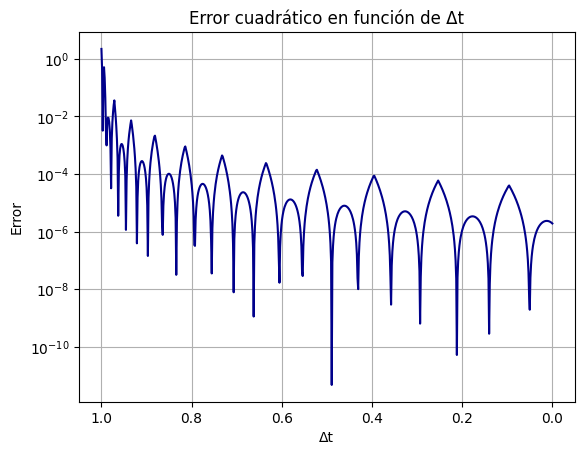

In [6]:
fig, ax = plt.subplots(1,1)
x = np.linspace(1,0,700)
ax.plot(x, Error, color='darkblue')
ax.invert_xaxis()
ax.grid()
plt.yscale("log")
plt.xlabel('Δt')
plt.ylabel('Error')
plt.title('Error cuadrático en función de Δt')
plt.show()

Función para calcular el precio de una Call Barrera Up and Out.

In [7]:
def Call_Barrier_UandO(Spot, Strike, Barrier, T, r, v, n):
    alpha = r - (0.5 * v * v)
    K = T / n
    exp_rT = math.exp(-r*K)
    N = round(math.log(Barrier/Spot)/(v*math.sqrt(3.0*K)) + 0.5)

    u = math.exp(math.log(Barrier/Spot)/N)
    d = 1/u

    pu = ((alpha*K)/(2*math.log(u))) + ((v*v*K)/(2*(math.log(u)**2)))
    pd = -(alpha*K)/(2*math.log(u)) + ((v*v*K)/(2*(math.log(u)**2)))
    pm = 1.0 - pu - pd

    A = np.zeros((2 * n + 1, n+1))
    A[n,0] = Spot

    #Árbol con los precios por cada tiempo
    for j in range(1, n+1):
        for i in range(n-j, n+j+1):
            cota = n
            if cota > i:
                A[i,j] = A[i+1,j-1] * u
            elif cota < i:
                A[i,j] = A[i-1,j-1] * d
            else:
                A[i,j] = A[i,j-1]

    #Op tendrá el valor de la opcion en cada nodo del arbol de precios S
    Op = np.zeros((2*n+1,n+1))

    Loc = 0
    for i in range(2 * n + 1):
        #Aca tengo cuidado con resta de numeros float en python, no siempre da 0 por ende no simpre el payoff en la
        # rama donde esta el precio de la barrera será 0
        distancia = np.abs(A[i,n]-Barrier)
        if distancia < 1e-10:
            Loc = i
            Op[i,n] = 0
        else:
            if A[i,n] >= Barrier : Op[i,n] = 0
            else : Op[i,n] = max(A[i,n] - Strike, 0)

    for i in range(1, 2 * n):
        if  i == Loc: Op[i,n - 1] = 0
        else:
            Op[i,n - 1] = exp_rT * (pu * Op[i-1, n] + pm * Op[i,n] + pd * Op[i+1, n])

    for j in range(n-2, -1, -1):
        for i in range(n-j, n+j+1):
            if i == Loc: Op[i,j] = 0
            else:
                Op[i,j] = exp_rT * (pu * Op[i-1, j+1] + pm * Op[i, j+1] + pd * Op[i+1, j+1])
    return Op[n,0]


Funciones auxiliares para comparar los resultados del algoritmo dado con los de la fórmula cerrada dada en el libro de Hull en la sección 24.6.

In [8]:
def lam(r, var):
    return (r + var**2 / 2) /var /var

def y(Barrier, S0, Strike, var, T, lam):
    return math.log(Barrier**2 / S0 / Strike) / var / math.sqrt(T) + lam * var * math.sqrt(T)

def x1(S0, Barrier, T, var, lam):
    return math.log(S0/Barrier) / var / math.sqrt(T) + lam * var * math.sqrt(T)

def y1(S0, Barrier, T, var, lam):
    return math.log(Barrier/S0) / var / math.sqrt(T) + lam * var * math.sqrt(T)

def c_up_in(S0,Strike,r,T,var,Barrier):
    l = lam(r,v)
    Y = y(Barrier,Spot,Strike,v,T,l)
    X1 = x1(Spot,Barrier,T,v,l)
    Y1 = y1(Spot,Barrier,T,v,l)
    return (S0*norm.cdf(X1) - Strike*math.exp(-r*T)*norm.cdf(X1-var*math.sqrt(T)) - S0*(Barrier/S0)**(2*l)*(norm.cdf(-Y) - norm.cdf(-Y1))
            + Strike*math.exp(-r*T)*(Barrier/S0)**(2*l-2)*(norm.cdf(-Y+var*math.sqrt(T)) - norm.cdf(-Y1+var*math.sqrt(T))))

def c_up_out(c, c_in):
    return c - c_in

Ahora compararemos el precio de la opción barrera generada por el algoritmo implementado y el precio de la misma opción barrera con la fórmula cerrada dada en el libro de Hull en la seccion 24.6 para distintas barreras H tales que H >> Strike.

In [9]:
c=Black_Scholes(Spot, Strike, T, r, v)
Barriers = [130 + 4*i for i in range(50)] + [400, 600, 800, 900]
Errores = [np.abs(c_up_out(c, c_up_in(Spot,Strike,r,T,v,Bs)) - Call_Barrier_UandO(Spot, Strike, Bs, T, r, v, n)) for Bs in Barriers]

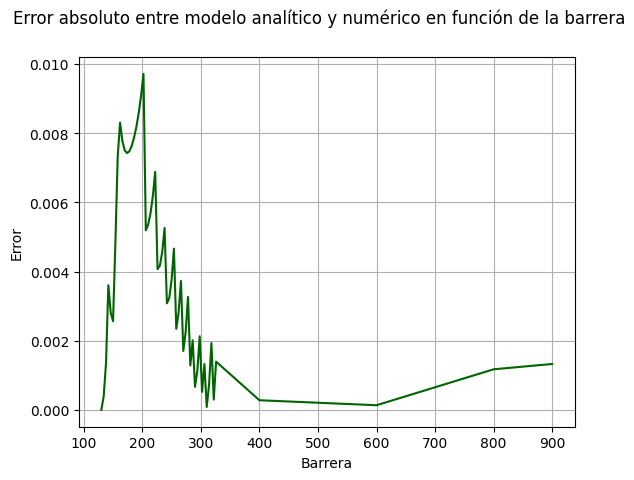

In [10]:
fig, ax = plt.subplots()
ax.plot(Barriers, Errores,color='darkgreen')
plt.suptitle('Error absoluto entre modelo analítico y numérico en función de la barrera')
plt.xlabel('Barrera')
plt.ylabel('Error')
plt.grid()
plt.show()

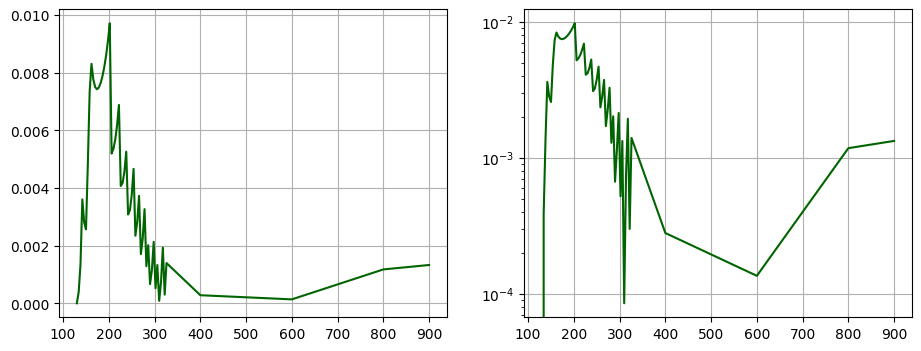

In [11]:
fig, ax = plt.subplots(1,2, figsize=(11,4))
ax[0].plot(Barriers, Errores, color='darkgreen')
ax[1].plot(Barriers, Errores, color='darkgreen')
ax[0].grid()
ax[1].grid()
plt.yscale("log")
plt.show()